출처: https://dacon.io/competitions/official/235867/codeshare/3909?page=3&dtype=recent

## Colab 셋팅

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install pandas==1.3.5
!pip install category_encoders
# runtime 재시작

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (9,122 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

## 라이브러리

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
#from category_encoders import BinaryEncoder

In [ ]:
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['font.size'] = 13

## 데이터 읽기

In [ ]:
path_train = '/content/drive/MyDrive/DACON/물류예측/data/train.csv'
path_test = '/content/drive/MyDrive/DACON/물류예측/data/test.csv'

X_train = pd.read_csv(path_train)#, encoding='cp949')
X_test = pd.read_csv(path_test)#, encoding='cp949')

In [ ]:
X_train

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수
0,0,5011000595017300,2871000192069300,음반,3
1,1,4148000690043300,5011000264024400,문화컨텐츠,3
2,2,5011000078068400,1120000007005400,농산물,3
3,3,4127100048006400,5011000587019400,기타식품,7
4,4,5011000078068400,2823700010076300,농산물,3
...,...,...,...,...,...
31679,31679,4471000290087200,5011000213073200,스포츠잡화,3
31680,31680,1129000014045300,5011000319087100,스마트디바이스,4
31681,31681,1129000014045300,5011000263065200,스마트디바이스,6
31682,31682,4127300065073100,5011000264061200,지갑,7


In [ ]:
X_test

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리
0,0,4167000577042200,5011000435014100,선케어
1,1,1156000009012200,5011000172034400,구강위생용품
2,2,4122000363057300,5011000361097300,캠핑
3,3,5011000436041400,2826000084036400,아웃도어가구
4,4,4150000241065200,5011000169044300,분유/이유식/아기간식
...,...,...,...,...
7915,7915,5011000266051200,4623000417038100,농산물
7916,7916,1154500001098300,5011000264055100,문화컨텐츠
7917,7917,5013000610049100,1147000018091400,농산물
7918,7918,5013000610049100,3117000039026100,농산물


In [ ]:
X_train.drop(['index'],axis=1,inplace=True)
X_test.drop(['index'],axis=1,inplace=True)

## feature engineering

In [ ]:
X_train.columns = ['SEND_SPG_INNB', 'REC_SPG_INNB', 'DL_GD_MCLS_NM', 'INVC_CONT']
X_test.columns = ['SEND_SPG_INNB', 'REC_SPG_INNB', 'DL_GD_MCLS_NM']
X_train

,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_MCLS_NM,INVC_CONT
0,5011000595017300,2871000192069300,음반,3
1,4148000690043300,5011000264024400,문화컨텐츠,3
2,5011000078068400,1120000007005400,농산물,3
3,4127100048006400,5011000587019400,기타식품,7
4,5011000078068400,2823700010076300,농산물,3
...,...,...,...,...
31679,4471000290087200,5011000213073200,스포츠잡화,3
31680,1129000014045300,5011000319087100,스마트디바이스,4
31681,1129000014045300,5011000263065200,스마트디바이스,6
31682,4127300065073100,5011000264061200,지갑,7


In [ ]:
X_train = X_train.astype({'SEND_SPG_INNB': 'str'})
X_train = X_train.astype({'REC_SPG_INNB': 'str'})
# X_train['SEND_SPG_INNB'] = X_train['SEND_SPG_INNB'].apply(lambda x: x[:-6])
# X_train['REC_SPG_INNB'] = X_train['REC_SPG_INNB'].apply(lambda x: x[:-6])

X_test = X_test.astype({'SEND_SPG_INNB': 'str'})
X_test = X_test.astype({'REC_SPG_INNB': 'str'})
# X_test['SEND_SPG_INNB'] = X_test['SEND_SPG_INNB'].apply(lambda x: x[:-6])
# X_test['REC_SPG_INNB'] = X_test['REC_SPG_INNB'].apply(lambda x: x[:-6])

In [ ]:
df = X_train[['SEND_SPG_INNB', 'REC_SPG_INNB', 'DL_GD_MCLS_NM', 'INVC_CONT']]
df[df['INVC_CONT'] >= 50]  # 운송장 건수 50 이상

,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_MCLS_NM,INVC_CONT
65,4371000161085100,5011000373016400,의료용품,77
285,4148000626030400,5011000319087400,가공식품,100
723,5011001069093300,3114000006044400,농산물,80
1275,5013000745036100,4311100051076200,농산물,81
1713,5013000866026400,4127300065073100,기타패션의류,53
...,...,...,...,...
30419,4157000128087200,5011000169077200,가공식품,56
30761,5011000530022100,1168000007069100,축산,89
31305,5013000865020400,4471000275004100,농산물,120
31637,4163000076030200,5011000318089300,과자,50


'DL_GD_MCLS_NM'(카테고리_중) 기준으로 운송량을 출력해보니 농산물이 압도적으로 많았습니다.
제주도 지역 운송 데이터니까 귤이 대부분일 것 같습니다.

<AxesSubplot:xlabel='DL_GD_MCLS_NM'>

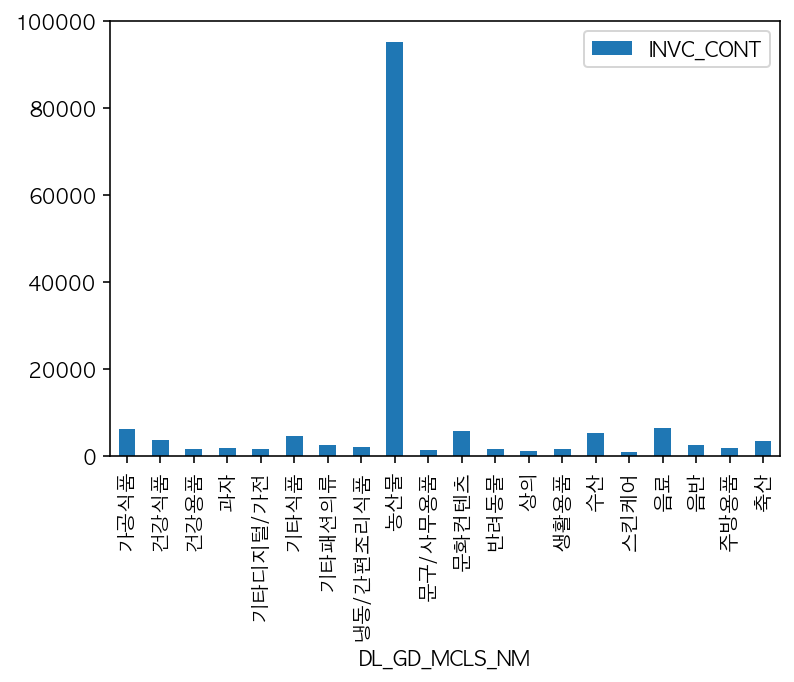

In [ ]:
df.groupby('DL_GD_MCLS_NM').sum().plot.bar()

제공 받은 데이터는 송화인이나 수화인 둘중 하나는 제주도이기에 처음에는 송화인이 제주도일 때, 수화인이 제주도일 때 두 가지로 데이터 프레임을 분할하여 모델링을 하였습니다. 
(구글링으로 제주도의 지역구 코드는 '50'으로 시작하는 것을 파악하였으며 이를 기준으로 나눌 수 있었습니다.)

모델링하기 전 변수 중요도를 파악하는 과정에서 수화인 주소 즉 'REC_SPG_INNB' 컬럼의 점수가 낮게 나왔습니다. 따라서 원점으로 돌아가 원래의 데이터에서 수화인 주소를 제거한 후 모델링을 다시 하였습니다.

## Label Encoding

In [ ]:
X_train.columns

Index(['SEND_SPG_INNB', 'REC_SPG_INNB', 'DL_GD_MCLS_NM', 'INVC_CONT'], dtype='object')

In [ ]:
LE1 = LabelEncoder()
LE2 = LabelEncoder()
LE3 = LabelEncoder()

y_train = X_train[['INVC_CONT']]
X_train.drop(columns=['index', 'REC_SPG_INNB', 'DL_GD_LCLS_NM', 'INVC_CONT'], inplace=True)

X_train['SEND_SPG_INNB'] = LE1.fit_transform(X_train['SEND_SPG_INNB'])
# X_train['REC_SPG_INNB'] = LE2.fit_transform(X_train['REC_SPG_INNB'])
X_train['DL_GD_MCLS_NM'] = LE3.fit_transform(X_train['DL_GD_MCLS_NM'])

for label in np.unique(X_test['SEND_SPG_INNB']):
    if label not in LE1.classes_:
        LE1.classes_ = np.append(LE1.classes_, label)
        
y_index = X_test[['index']]
X_test.drop(columns=['index', 'REC_SPG_INNB', 'DL_GD_LCLS_NM'], inplace=True)

X_test['SEND_SPG_INNB'] = LE1.transform(X_test['SEND_SPG_INNB'])
X_test['DL_GD_MCLS_NM'] = LE3.transform(X_test['DL_GD_MCLS_NM'])

라벨인코딩과 바이너리인코딩을 각각 사용해봤는데, 라벨 인코딩 성능이 더 좋게 나와서 라벨인코딩을 선택했습니다.

## Binary Encoding

In [ ]:
# labelencoder = LabelEncoder()

# y_train = X_train[['INVC_CONT']]
# X_train.drop(columns=['index', 'REC_SPG_INNB', 'DL_GD_LCLS_NM', 'INVC_CONT'], inplace=True)
# binaryencoder = BinaryEncoder(cols=['DL_GD_MCLS_NM'], return_df=True)

# X_train = binaryencoder.fit_transform(X_train)
# X_train['SEND_SPG_INNB'] = labelencoder.fit_transform(X_train['SEND_SPG_INNB'])

# y_index = X_test[['index']]
# X_test.drop(columns=['index', 'REC_SPG_INNB', 'DL_GD_LCLS_NM'], inplace=True)
# X_test = binaryencoder.transform(X_test)
# X_test['SEND_SPG_INNB'] = labelencoder.transform(X_test['SEND_SPG_INNB'])

## 모델링

랜덤포레스트회귀, XGBoost회귀, 의사결정나무회귀 모델을 Grid Search에 넣어서 가장 좋은 하이퍼파라미터와 모델 조합을 찾아 선택할 수 있었습니다.

In [ ]:
pipe = Pipeline([('regressor', RandomForestRegressor())])
search_space = [
                {
                 'regressor': [RandomForestRegressor(random_state=0)],
                 'regressor__n_estimators': [100, 150, 200],
                 'regressor__max_depth': [3, 4, 5]
                },
                
                {
                 'regressor': [XGBRegressor()],
                 'regressor__max_depth': [3],
                 'regressor__n_estimators': [300],
                 'regressor__eta': [0.02, 0.1],
                 'regressor__subsample': [0.5, 0.6],
                 'regressor__seed':[0]
                },
                
                {
                 'regressor': [DecisionTreeRegressor(random_state=0)],
                 'regressor__min_samples_split':[3, 4, 5],
                 'regressor__max_depth': [3, 4, 5]
                }
               ]

In [ ]:
kf = KFold(n_splits=9,random_state=None)
grid_search = GridSearchCV(pipe,search_space, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

print('best params:', grid_search.best_params_)
print('best estimator:', grid_search.best_estimator_)
print('best rmse :', sqrt(-(grid_search.best_score_)))

best params: {'regressor': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eta=0.1, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=3,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, seed=0, subsample=0.6, tree_method=None,
             validate_parameters=None, verbosity=None), 'regressor__eta': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 300, 'regressor__seed': 0, 'regressor__subsample': 0.6}
best estimator: Pipeline(steps=[('regressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_

실행 결과 셋 중에서 XGBRegressor가 가장 좋은 성능을 보여주었습니다.

## 예측값 출력

In [ ]:
y_test_pred = pd.DataFrame(grid_search.best_estimator_.predict(X_test), columns=['INVC_CONT'])
y_test_pred = pd.concat([y_index, y_test_pred], axis=1)
y_test_pred.to_csv('/content/drive/MyDrive/submission.csv', index=False)